# **Data Science for Business - Group Project Part 2**

---
---

## 1.  **Work Environment Set Up** 
 
Thanks to the Labels.txt file we know the label of each image contained in the Character_Images folder. Thus We start by sorting all images by their label in different folders. At the same timewe create a train and validation set along the tyical 80/20 % proportion. 


In [52]:
import os
from sklearn.model_selection import train_test_split
import shutil
from collections import defaultdict

# Paths
image_folder = './Character_Images'
labels_file = './Labels.txt'
categorized_folder = './Categorized_Character_images'
train_folder = os.path.join(categorized_folder, 'train')
val_folder = os.path.join(categorized_folder, 'validation')

# Load labels and format them
labels_dict = {}
with open(labels_file, 'r') as file:
    for line in file:
        key, value = line.strip().split(',')
        formatted_filename = key.strip() + ".png"
        labels_dict[formatted_filename] = value.strip()

# Ensure folders exist for each class
label_classes = set(labels_dict.values())
for label_class in label_classes:
    os.makedirs(os.path.join(train_folder, label_class), exist_ok=True)
    os.makedirs(os.path.join(val_folder, label_class), exist_ok=True)

# Group filenames by label
files_by_label = defaultdict(list)
for filename, label in labels_dict.items():
    files_by_label[label].append(filename)

# Split files into train and validation ensuring 80/20 proportion for each label
train_files = []
val_files = []
for label, files in files_by_label.items():
    # Perform the split for each label
    train_split, val_split = train_test_split(files, test_size=0.2, random_state=42)
    # Organize train and validation files by label
    train_files.extend([(file, label) for file in train_split])
    val_files.extend([(file, label) for file in val_split])

# Function to copy files into categorized folders
def copy_files_to_categorized_folders(file_list, src_folder, dst_folder):
    for filename, label in file_list:
        src_path = os.path.join(src_folder, filename)
        dst_label_folder = os.path.join(dst_folder, label)
        dst_path = os.path.join(dst_label_folder, filename)
        if os.path.exists(src_path):
            shutil.copy2(src_path, dst_path)
        else:
            print(f"Warning: File not found: {src_path}")

# Organize files into train and validation folders
copy_files_to_categorized_folders(train_files, image_folder, train_folder)
copy_files_to_categorized_folders(val_files, image_folder, val_folder)

print("Files successfully organized into train and validation folders.")

# Verify the split
def count_files_by_label(folder):
    counts = {}
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            counts[label] = len(os.listdir(label_path))
    return counts

train_counts = count_files_by_label(train_folder)
val_counts = count_files_by_label(val_folder)

print("Train folder distribution:", train_counts)
print("Validation folder distribution:", val_counts)

Files successfully organized into train and validation folders.
Train folder distribution: {'9': 2605, '0': 7684, '7': 2824, '6': 6672, '1': 4522, '8': 7053, 'C': 816, '4': 3284, 'X': 888, '3': 3701, 'E': 812, '2': 4071, '5': 15018}
Validation folder distribution: {'9': 652, '0': 1921, '7': 706, '6': 1668, '1': 1131, '8': 1764, 'C': 204, '4': 822, 'X': 223, '3': 926, 'E': 203, '2': 1018, '5': 3755}


One early observation is that the digit 5 is  overrepresented in the dataset. This imbalance will be important to address during model training, as it may lead to the model favoring this class disproportionately. 

Now that we have organized all the images, we can have a look at some of them to see if and what kind of data augmentation is needed

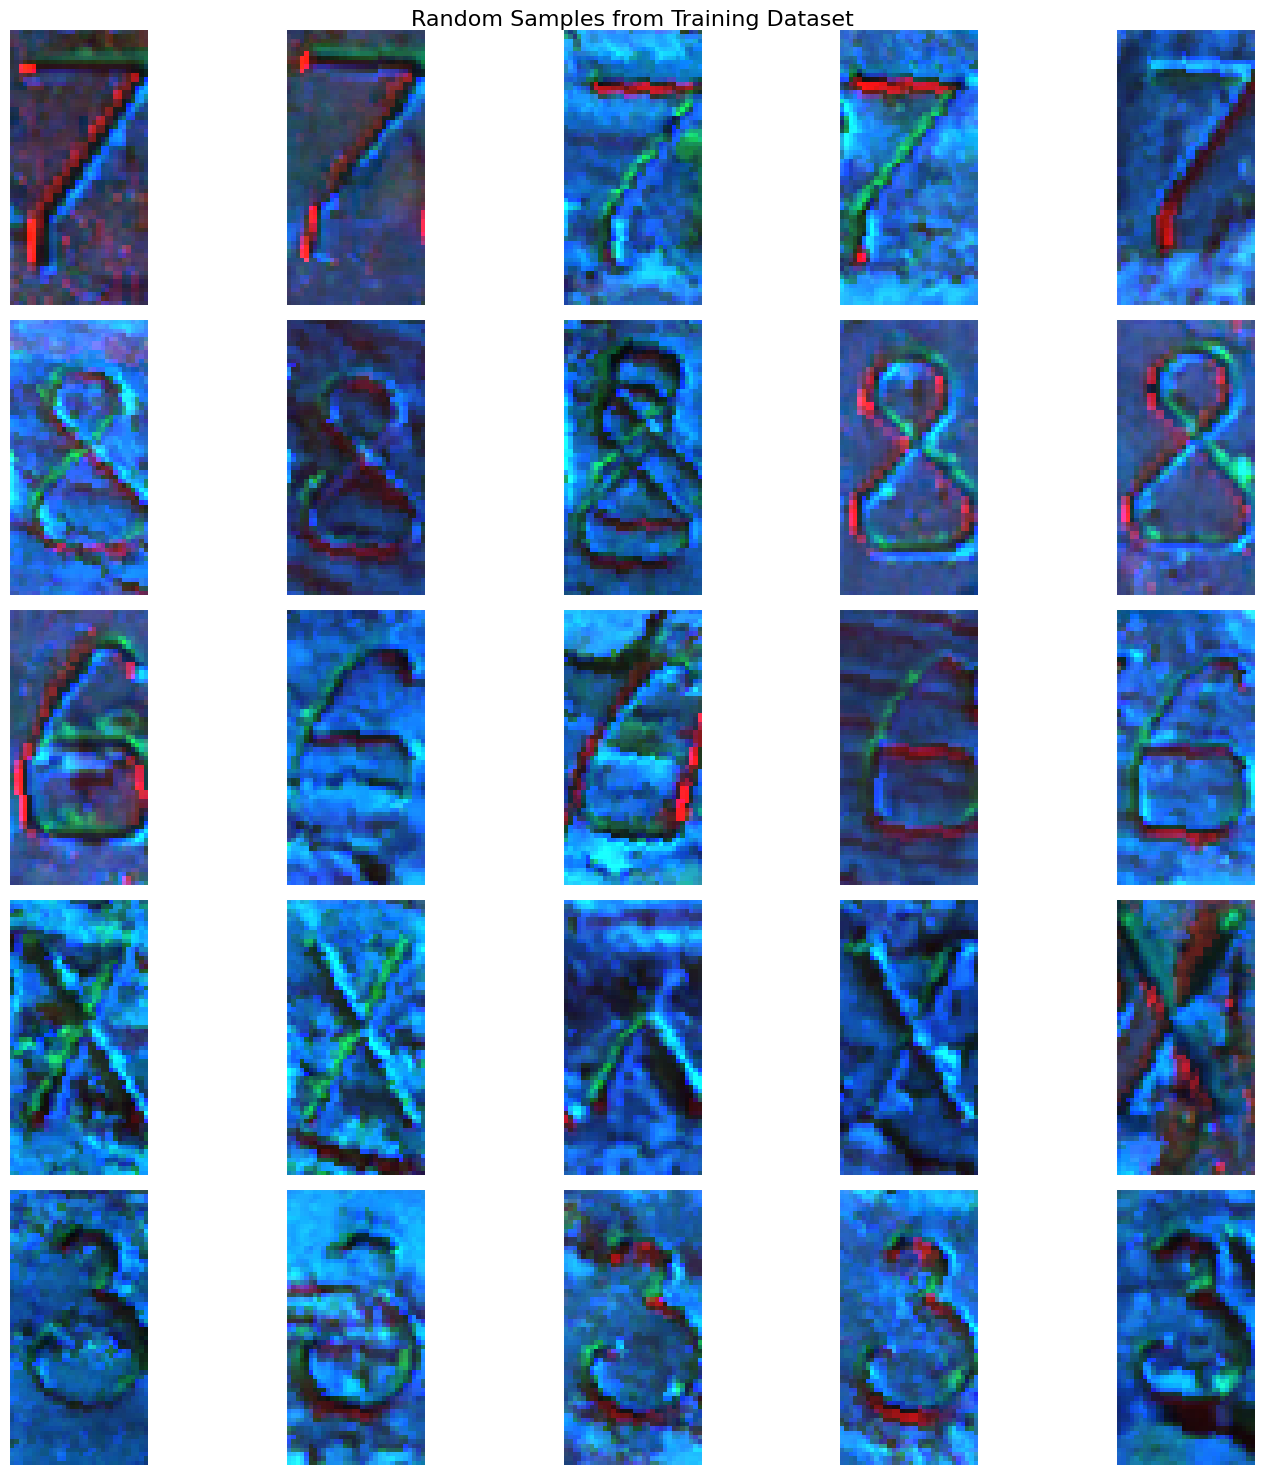

In [53]:
import matplotlib.pyplot as plt
import os
import random
from keras.preprocessing.image import load_img, img_to_array

# Paths to the train folder
train_folder = './Categorized_Character_images/train'

# Function to visualize random samples
def visualize_random_samples(folder, num_classes=5, num_images_per_class=5, img_size=(64, 32)):
    """
    Display random images from the dataset for a subset of classes.
    
    Parameters:
        folder (str): Path to the folder containing class subdirectories.
        num_classes (int): Number of classes to sample.
        num_images_per_class (int): Number of images per class to display.
        img_size (tuple): Target size for loading images.
    """
    classes = sorted(os.listdir(folder))
    sampled_classes = random.sample(classes, min(num_classes, len(classes)))

    plt.figure(figsize=(15, num_classes * 3))
    for i, class_label in enumerate(sampled_classes):
        class_folder = os.path.join(folder, class_label)
        if not os.path.isdir(class_folder):
            continue
        
        image_files = os.listdir(class_folder)
        sampled_images = random.sample(image_files, min(num_images_per_class, len(image_files)))
        
        for j, img_file in enumerate(sampled_images):
            img_path = os.path.join(class_folder, img_file)
            img = load_img(img_path, target_size=img_size)
            plt.subplot(num_classes, num_images_per_class, i * num_images_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.ylabel(class_label, fontsize=14)
    
    plt.suptitle('Random Samples from Training Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_random_samples(train_folder, num_classes=5, num_images_per_class=5)

The background consistently features a mix of red and blue, while the digits are often slightly off-center, inconsistently scaled, and occasionally tilted. Based on these observations, we will apply the following data augmentations:
1.	Color Channel Variations: To introduce variability in the red and blue channels of the background.
2.  Vertical and Horizontal Shifting: To account for digits not being perfectly centered.
3.	Zooming In and Out: To address variations in digit scaling.
4.	Rotation: To simulate slight tilts in the orientation of the digits.
5.  Blur: To simulate the different material texture.

To improve efficiency, we will utilize Keras’s online data augmentation feature(ImageDataGenerator). This approach allows us to apply augmentations dynamically during model training, eliminating the need to store all augmented images in memory. This not only saves storage space but also ensures that the model sees a varied set of augmented data in each epoch, enhancing its generalization capabilities.

## 2.  **Data Augmentation** 



In [54]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
import numpy as np
import scipy
import os

def color_shift_and_blur(image):
    """Applies a random shift to the red and blue channels and a random Gaussian blur."""
    # Color shift
    red_shift = np.random.uniform(-30, 30)  
    blue_shift = np.random.uniform(-30, 30)  
    image[..., 0] = np.clip(image[..., 0] + red_shift, 0, 255)  # Adjust red channel
    image[..., 2] = np.clip(image[..., 2] + blue_shift, 0, 255)  # Adjust blue channel
    
    # Gaussian blur
    if np.random.rand() < 0.05:
        kernel_size = np.random.choice([1, 3])
        image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)  # Apply blur
    
    return image

datagen = ImageDataGenerator(
    rotation_range=5,              # Random rotation (degrees)
    width_shift_range=0.005,       # Horizontal translation (fraction of total width)
    height_shift_range=0.005,      # Vertical translation (fraction of total height)
    shear_range=0.2,                # Shear intensity (shear angle in counter-clockwise direction in degrees)
    zoom_range=0.05,                # Random zoom
    horizontal_flip=False,     
    fill_mode='nearest',            # Fill pixels after transformation
    preprocessing_function=color_shift_and_blur
)

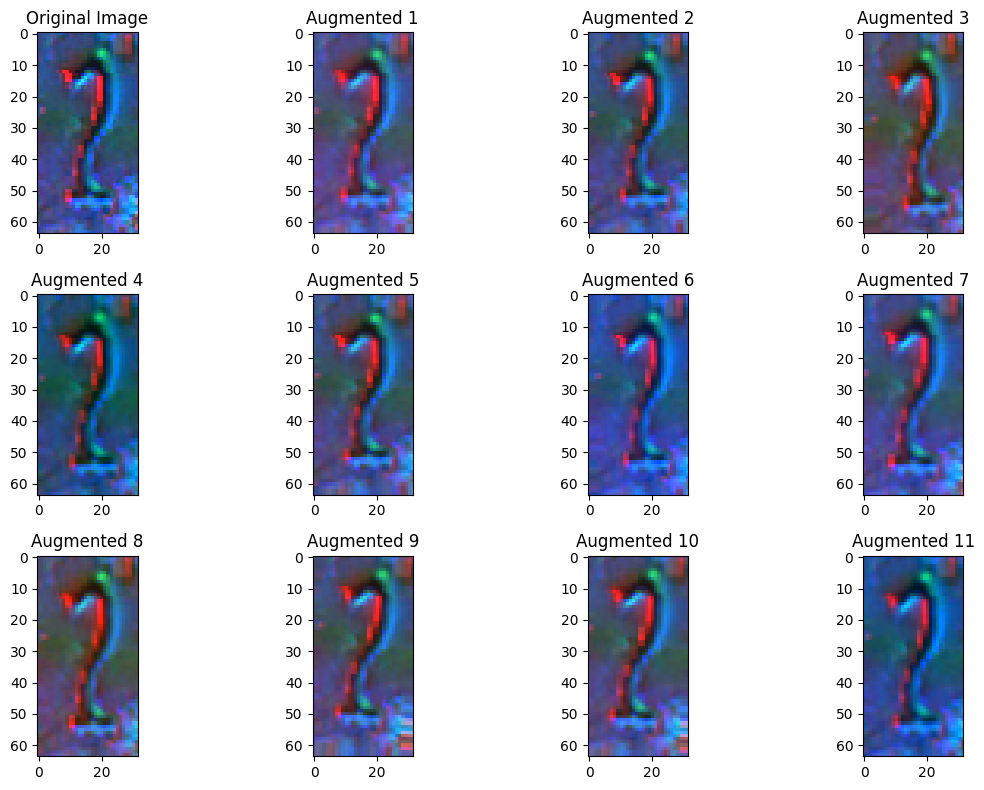

In [55]:
image_path = './Character_Images/sample_04152.png'

# Load the sample image
img = load_img(image_path, target_size=(64, 32)) 
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  

plt.figure(figsize=(12, 8))
plt.subplot(3, 4, 1)
plt.imshow(img_array[0].astype('uint8')) 
plt.title("Original Image")

# Apply standard augmentations and custom color shift
for i, batch in enumerate(datagen.flow(img_array, batch_size=1)):
    if i >= 11:  # Generate only 11 augmented images
        break
    augmented_image = batch[0].astype('uint8') 
    plt.subplot(3, 4, i + 2)
    plt.imshow(augmented_image)
    plt.title(f"Augmented {i+1}")

plt.tight_layout()
plt.show()

In [ ]:
import os
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
import numpy as np

# Paths
augmented_folder = './Augmented_Character_Images'  # Backup folder for augmented images (optional)
os.makedirs(augmented_folder, exist_ok=True)

# Function to augment images
def augment_class_images(class_folder, class_label, num_augmentations):
    images = os.listdir(class_folder)
    print(f"Augmenting class '{class_label}' with {num_augmentations} additional images...")
    augmented_count = 0  # Track how many images we've added

    while augmented_count < num_augmentations:
        for img_name in images:
            img_path = os.path.join(class_folder, img_name)
            img = load_img(img_path, target_size=(64, 32))  # Resize for consistency
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            # Generate augmented images
            for batch in datagen.flow(img_array, batch_size=1):
                augmented_filename = f"{os.path.splitext(img_name)[0]}_aug_{augmented_count}.png"
                save_path = os.path.join(class_folder, augmented_filename)

                # Save augmented image
                save_img(save_path, batch[0])

                # Optional: Save a backup
                os.makedirs(os.path.join(augmented_folder, class_label), exist_ok=True)
                backup_path = os.path.join(augmented_folder, class_label, augmented_filename)
                save_img(backup_path, batch[0])

                augmented_count += 1
                if augmented_count >= num_augmentations:
                    break

            if augmented_count >= num_augmentations:
                break

# Analyze class distribution
class_distribution = {
    class_label: len(os.listdir(os.path.join(train_folder, class_label)))
    for class_label in os.listdir(train_folder)
}
print(class_distribution)
max_class_count = max(class_distribution.values())
print(max_class_count)
# Augment images for all classes
augmentation_factor = 0.5  # Increase dataset size to 1.5x the largest class
target_count = int(max_class_count * augmentation_factor)

for class_label, class_count in class_distribution.items():
    class_folder = os.path.join(train_folder, class_label)
    num_augmentations = target_count - class_count
    if num_augmentations > 0:
        augment_class_images(class_folder, class_label, num_augmentations)

print("Dataset augmentation completed!")

{'9': 2605, '0': 7684, '7': 2824, '6': 6672, '1': 4522, '8': 7053, 'C': 816, '4': 3284, 'X': 888, '3': 3701, 'E': 812, '2': 4071, '5': 15018}
15018
Augmenting class '9' with 4904 additional images...
Augmenting class '7' with 4685 additional images...
Augmenting class '6' with 837 additional images...
Augmenting class '1' with 2987 additional images...
Augmenting class '8' with 456 additional images...
Augmenting class 'C' with 6693 additional images...
Augmenting class '4' with 4225 additional images...
Augmenting class 'X' with 6621 additional images...
Augmenting class '3' with 3808 additional images...
Augmenting class 'E' with 6697 additional images...
Augmenting class '2' with 3438 additional images...
Dataset augmentation completed!


## 3.  **Model Definition** 


LeNet is a classic convolutional neural network (CNN) architecture designed specifically for character recognition tasks, making it a perfect fit for this project. It is computationally efficient, well-suited for smaller datasets, and requires fewer resources compared to deeper networks like AlexNet. LeNet’s simplicity and proven performance on similar OCR tasks ensure that it effectively captures key features of digits or characters while avoiding overfitting on a limited dataset. Additionally, it can handle 64x32 images with minimal modification, making it ideal for this project.

For more info about Lenet : https://en.wikipedia.org/wiki/LeNet

In [84]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Improved LeNet Architecture
def create_lenet(input_shape=(64, 32, 3), num_classes=13):
    model = Sequential()

    # Layer 1: Convolution + Activation + Pooling
    model.add(Conv2D(6, kernel_size=(5, 5), strides=1, padding='same', kernel_initializer='he_normal', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Layer 2: Convolution + Activation + Pooling
    model.add(Conv2D(16, kernel_size=(5, 5), strides=1, padding='valid', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Flatten
    model.add(Flatten())

    # Fully Connected Layer 1 + Dropout
    model.add(Dense(120, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # Fully Connected Layer 2 
    model.add(Dense(84, kernel_initializer='he_normal'))
    model.add(Activation('relu'))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model


# Create and compile the improved model
lenet_model = create_lenet()
lenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
lenet_model.summary()

# Callback: Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 32, 6)         456       
                                                                 
 activation_14 (Activation)  (None, 64, 32, 6)         0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 16, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 12, 16)        2416      
                                                                 
 batch_normalization_9 (Bat  (None, 28, 12, 16)        64        
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 28, 12, 16)       

## 4.  **Model Training** 


In [85]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

train_datagen = datagen
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(32, 64),
    batch_size=64,
    class_mode='categorical' 
)

val_generator = test_datagen.flow_from_directory(
    val_folder,
    target_size=(32, 64),
    batch_size=64,
    class_mode='categorical',
    shuffle=False 
)

Found 105301 images belonging to 13 classes.
Found 14993 images belonging to 13 classes.


In [86]:
# Train the model
history = lenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    verbose=1
)

Epoch 1/15
1646/1646 [==============================] - 64s 38ms/step - loss: 0.1417 - accuracy: 0.9596 - val_loss: 0.0482 - val_accuracy: 0.9857
Epoch 2/15
1646/1646 [==============================] - 62s 38ms/step - loss: 0.0326 - accuracy: 0.9900 - val_loss: 0.0247 - val_accuracy: 0.9925
Epoch 3/15
1646/1646 [==============================] - 64s 39ms/step - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.0340 - val_accuracy: 0.9897
Epoch 4/15
1646/1646 [==============================] - 64s 39ms/step - loss: 0.0192 - accuracy: 0.9942 - val_loss: 0.0194 - val_accuracy: 0.9942
Epoch 5/15
1646/1646 [==============================] - 65s 40ms/step - loss: 0.0155 - accuracy: 0.9949 - val_loss: 0.0211 - val_accuracy: 0.9938
Epoch 6/15
1646/1646 [==============================] - 65s 40ms/step - loss: 0.0145 - accuracy: 0.9955 - val_loss: 0.0228 - val_accuracy: 0.9938
Epoch 7/15
1646/1646 [==============================] - 64s 39ms/step - loss: 0.0116 - accuracy: 0.9963 - val_loss: 0.0217 -

In [87]:
lenet_model.save('./Lenetv3.h5')

/Users/paulrichard/miniconda3/envs/STGCN/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 5.  **Model Performance** 



### Training and Validation Metrics ###


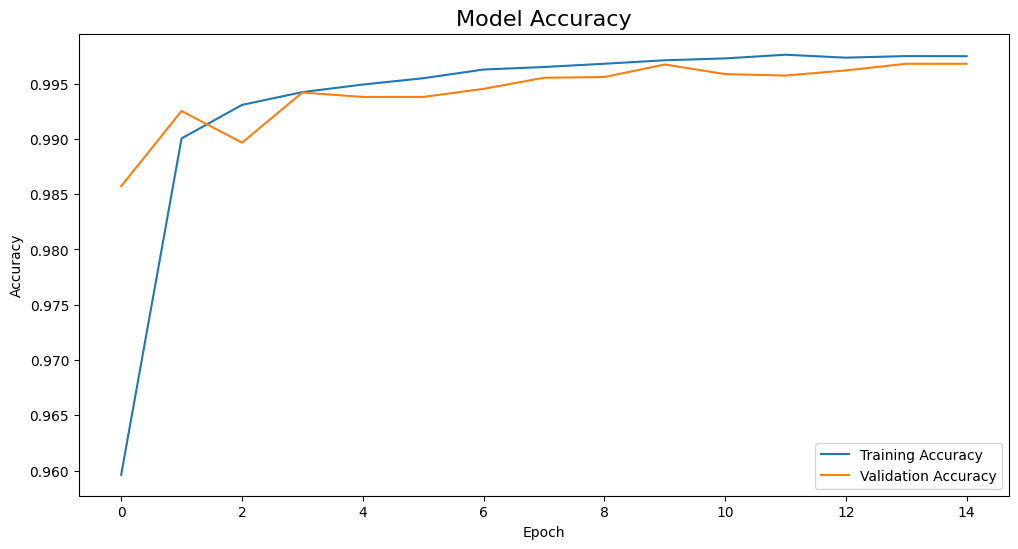

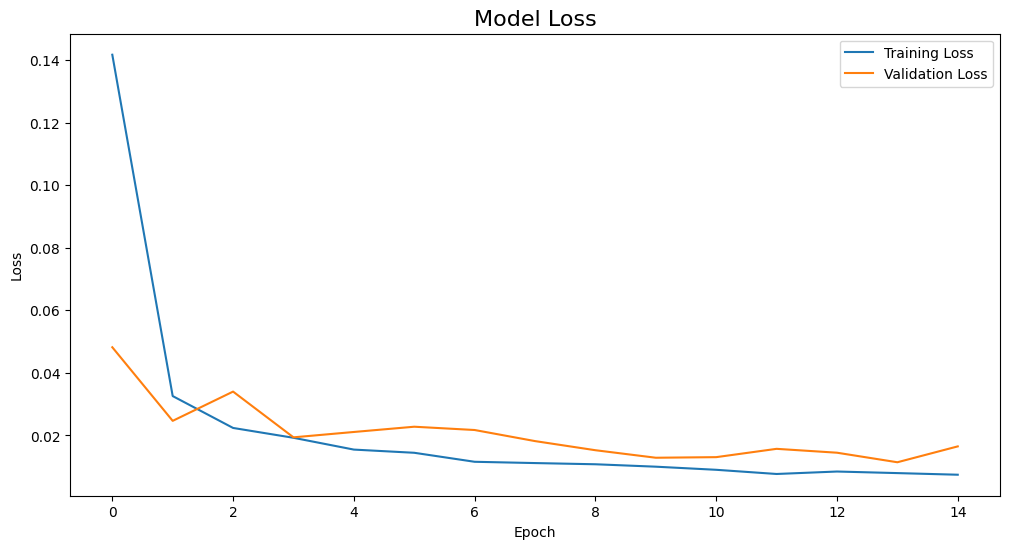


### Evaluation Metrics ###
Test Loss: 0.1158
Test Accuracy: 0.9655
Train Loss: 0.0752
Train Accuracy: 0.9779

### Classification Report and Confusion Matrix ###
235/235 [==============================] - 3s 12ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1921
           1       0.99      1.00      1.00      1131
           2       1.00      1.00      1.00      1018
           3       0.99      1.00      1.00       926
           4       1.00      1.00      1.00       822
           5       1.00      1.00      1.00      3755
           6       0.99      1.00      1.00      1668
           7       0.99      1.00      0.99       706
           8       1.00      0.99      1.00      1764
           9       1.00      1.00      1.00       652
           C       1.00      0.99      0.99       204
           E       0.99      0.99      0.99       203
           X       1.00      1.00      1.00       223

 

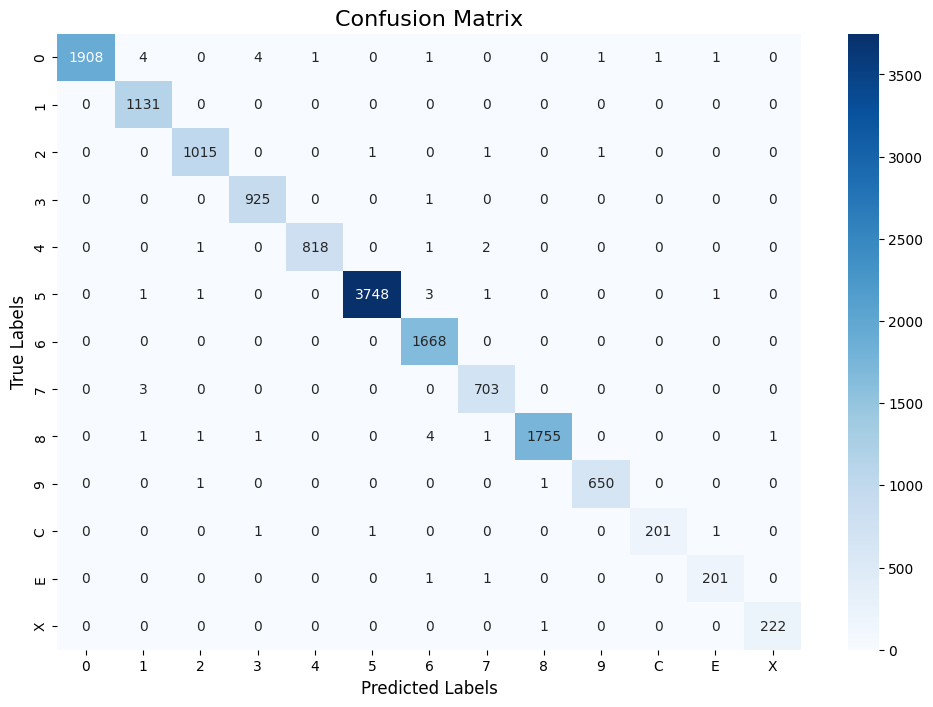


### Misclassified Images ###


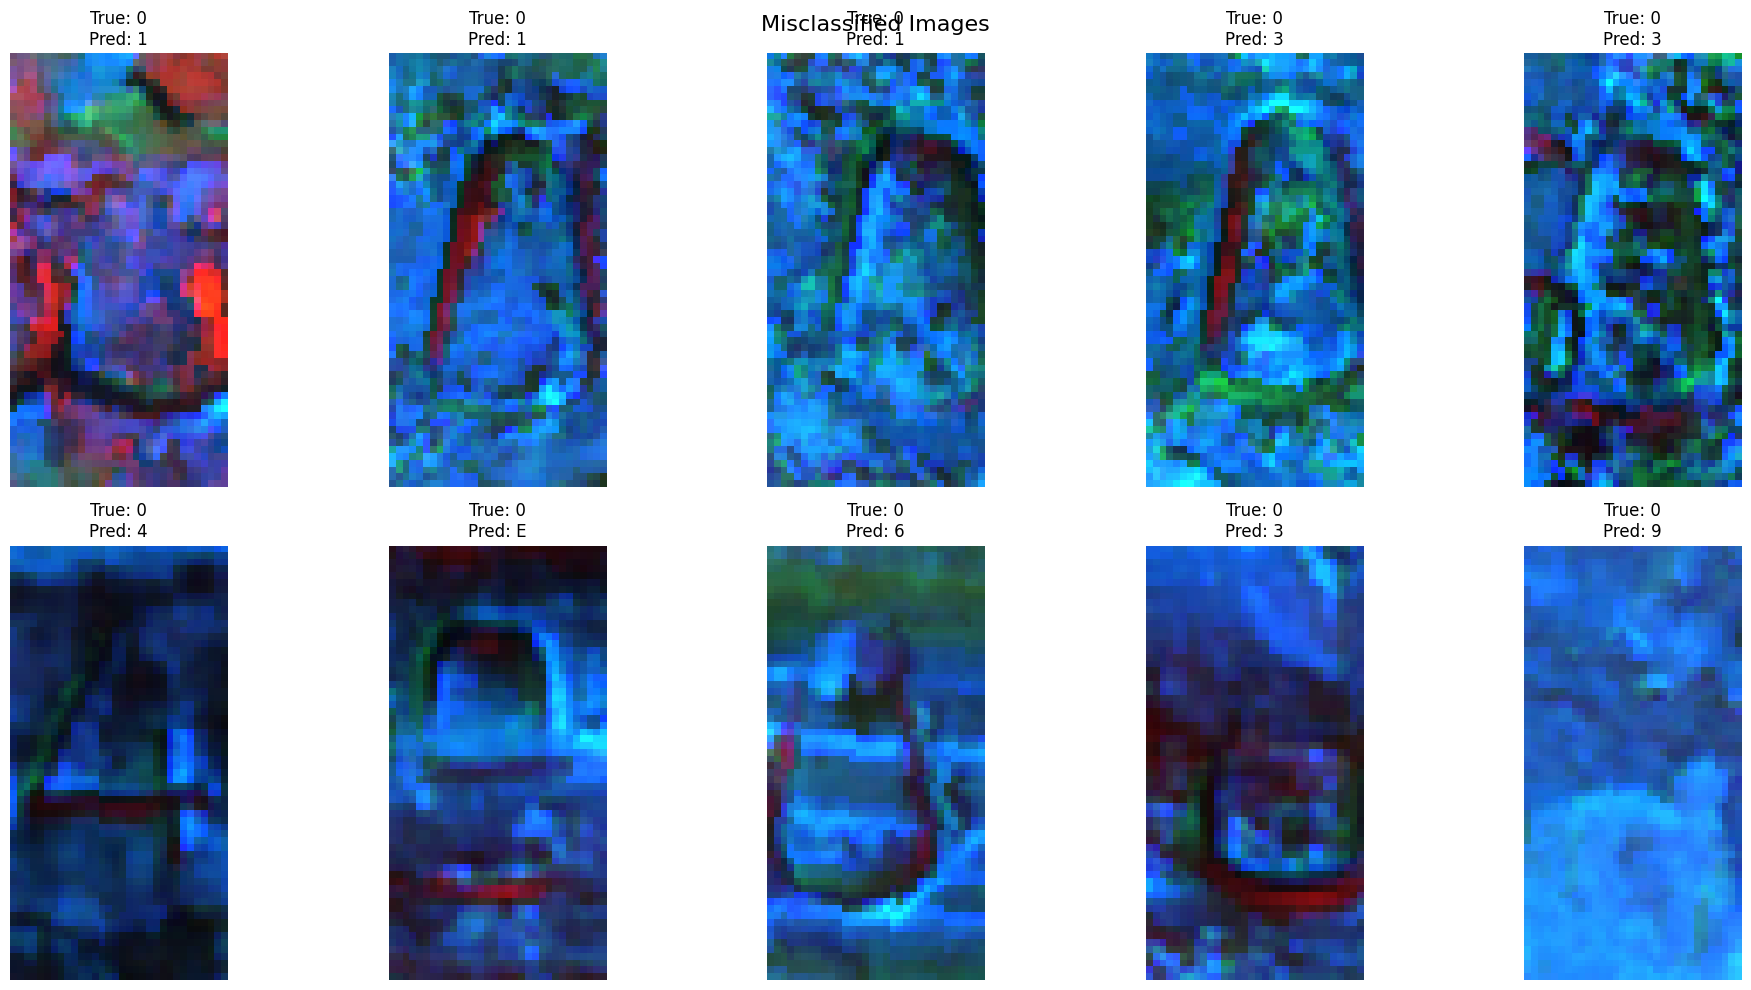

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.models import load_model

# Section 1: Plot Training and Validation Metrics
print("\n### Training and Validation Metrics ###")
model = load_model('Lenetv2.h5')

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Section 2: Evaluate Model on Training and Validation Data
print("\n### Evaluation Metrics ###")

test_loss, test_accuracy = model.evaluate(val_generator, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

# Section 3: Classification Report and Confusion Matrix
print("\n### Classification Report and Confusion Matrix ###")

# Predict all validation data
validation_steps = np.ceil(val_generator.samples / val_generator.batch_size).astype(int)
validation_predictions = lenet_model.predict(val_generator, steps=validation_steps, verbose=1)
validation_true_classes = np.array(val_generator.classes)[:len(validation_predictions)]  # Truncate to match predictions
validation_predicted_classes = np.argmax(validation_predictions, axis=1)  # Predicted labels

# Classification report
class_labels = list(val_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(validation_true_classes, validation_predicted_classes, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(validation_true_classes, validation_predicted_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Section 4: Display Misclassified Images
print("\n### Misclassified Images ###")

# Identify misclassified indices
misclassified_indices = np.where(validation_true_classes != validation_predicted_classes)[0]

# Limit the number of images to display
num_to_display = min(len(misclassified_indices), 10)

# Display misclassified images
plt.figure(figsize=(20, 10))

for i, index in enumerate(misclassified_indices[:num_to_display]):
    # Map the index to the filename in the validation generator
    img_path = os.path.join(val_folder, val_generator.filenames[index])
    true_label = class_labels[validation_true_classes[index]]
    predicted_label = class_labels[validation_predicted_classes[index]]
    
    # Load the image
    img = load_img(img_path, target_size=(64, 32))
    img_array = img_to_array(img)
    
    # Plot the image
    plt.subplot(2, 5, i + 1)  # Adjust grid size dynamically
    plt.imshow(img_array.astype('uint8'))
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Misclassified Images", fontsize=16)
plt.show()

## 6.  **Model Saving** 


In [89]:
test_loss, test_accuracy = lenet_model.evaluate(val_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

train_loss, train_accuracy = lenet_model.evaluate(train_generator)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

235/235 [==============================] - 2s 9ms/step - loss: 0.0165 - accuracy: 0.9968
Test Loss: 0.016500921919941902
Test Accuracy: 0.9967985153198242
1646/1646 [==============================] - 58s 35ms/step - loss: 0.0028 - accuracy: 0.9991
Train Loss: 0.0027698723133653402
Train Accuracy: 0.9990978240966797
